In [1]:
## Load TEDS-D 2017 Data into a Pandas Data Frame
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

## Specify WD
wd = "/home/abf/BINF667013_Final_Project/"
os.chdir(wd)

teds=pd.read_csv("datasets/tedsd_puf_2017.csv")
teds

## Convert '-9' to NA
teds=teds.replace({-9:np.nan})

## make a subset for development
#teds=teds.iloc[1:1000, ]

### Count the number of complete cases in this dataset

In [40]:
teds.dropna().shape

(11, 76)

### Count the number of cases with valid observations for at least 50% of available measures

In [41]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 39, axis=1)
teds[mask].shape

(9999, 76)

### Count the number of cases with valid observations for at least 75% of available measures

In [42]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 19, axis=1)
teds[mask].shape

(9663, 76)

### Count the number of cases with valid observations for at least 90% of available measures

In [22]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 8, axis=1)
teds[mask].shape

(196108, 76)

### Explore Correlation between missing values

<AxesSubplot:>

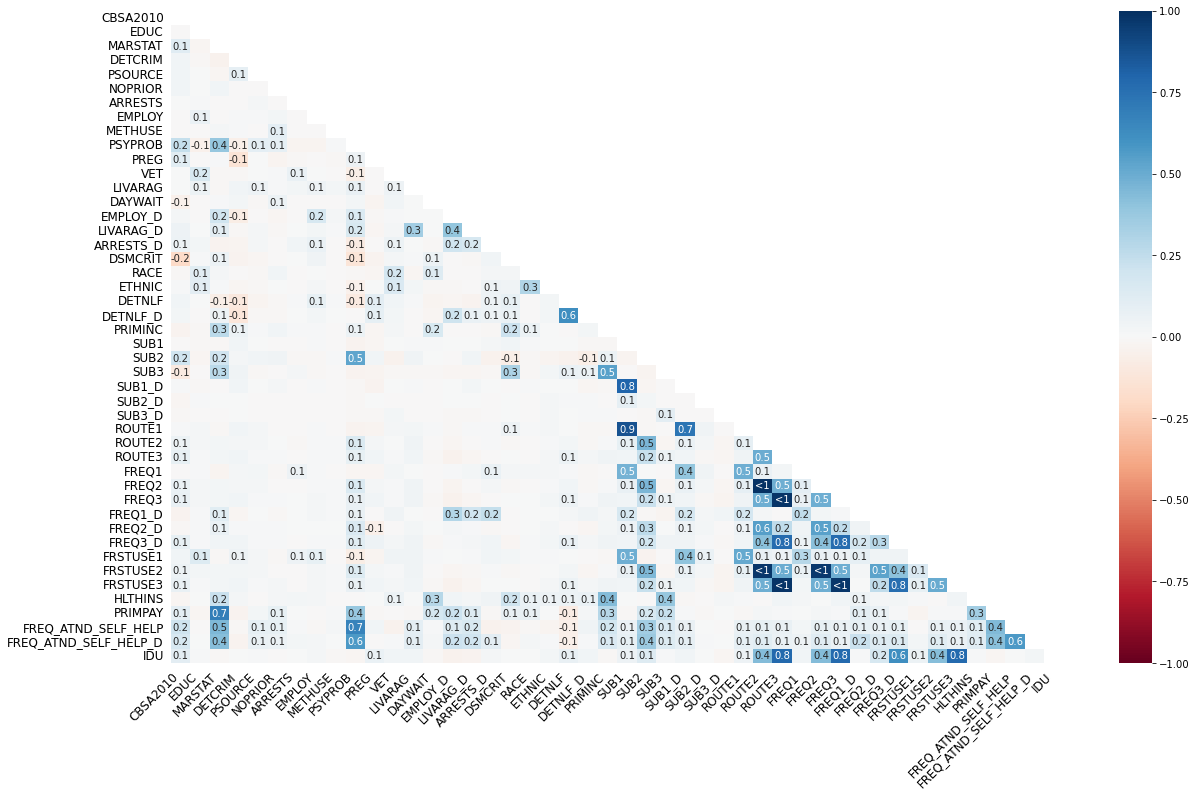

In [43]:
import missingno as msno
msno.heatmap(teds, fontsize=12)

<AxesSubplot:>

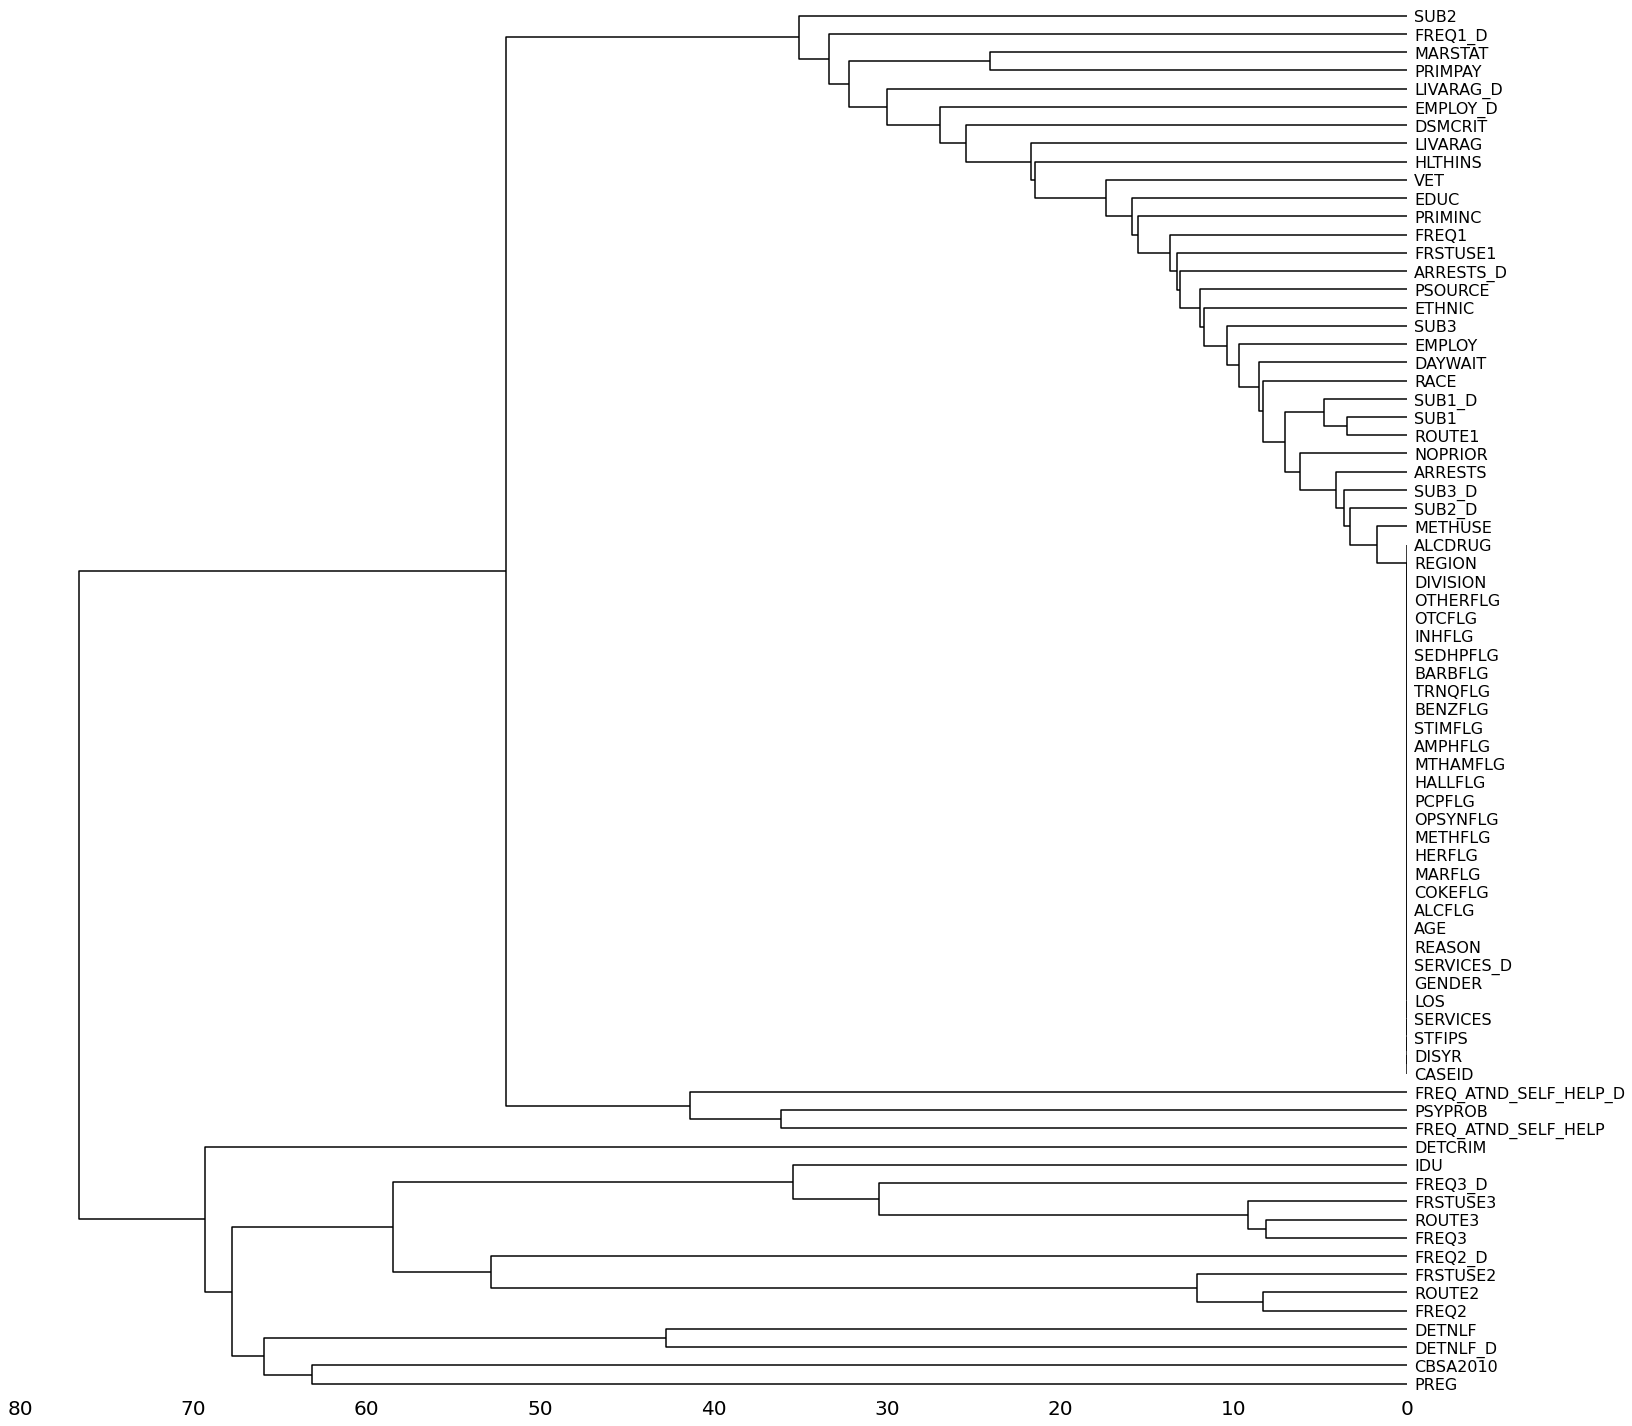

In [44]:
msno.dendrogram(teds)

### Convert Observations to Categorical Variables

In [5]:
for col in teds.columns:
    if not (col =="CASEID" or col == "DISYR"):
        teds[col] = teds[col].astype('category')

### Use MissForest implemented in missingpy to impute missing values

In [2]:
## Stupid hack because due to broken module name #WastingMyTime #SloppyCode
import sys
import sklearn.neighbors
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from os.path import exists

if exists("analysis_objects/teds_imputed.csv"):
    teds_imputed=pd.read_csv("analysis_objects/teds_imputed.csv")
else:
    ## Run imputation
    imputer = MissForest(
        random_state=123,
        criterion=('squared_error', 'gini') # Package mispecifies criterion
    )  
    X=imputer.fit_transform(
        teds.drop(columns=['CASEID', 'DISYR']),
        cat_vars=np.array([x for x in range(0,74)])
    )

    teds_imputed=pd.DataFrame(X)
    teds_imputed.columns=teds.columns[2:76]
    teds_imputed.to_csv(
        path_or_buf="analysis_objects/teds_imputed.csv"
    )


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
